# add_features
* 새로 만들어본 변수들을 잡다하게 넣어본다 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss


import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
path = "./data/"
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [5]:
train_df.shape, test_df.shape

((199991, 22), (10009, 21))

## DATA Setting

In [6]:
def del_outlier(data, min=0, max=60):
    up_idx_t=()
    dw_idx_t=()
    train_light = data.iloc[:,2:]
    for i in range(len(train_light.columns)):
        col = train_light.columns[i]
        up_idx_t+=tuple(data[data[col]>max].index)
        dw_idx_t+=tuple(data[data[col]<min].index)
    del_idx = set(up_idx_t+dw_idx_t)
    
    return data[~data.index.isin(del_idx)]

In [7]:
train_df = del_outlier(train_df, min=-60, max=60)

In [8]:
train_df.shape

(199805, 22)

In [9]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [10]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [12]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [13]:
train_df = add_minus_feature_all(train_df)
test_df = add_minus_feature_all(test_df,True)

In [14]:
def fiberID_agg(data):
    '''
    fiberID는 1~1000까지 숫자로 구성되어있는 카테고리 변수다.
    numeric한 변수가 아니기때문에 이를 이용한 변수 생성이 필요하다 판단되어
    ugriz밴드를 기반으로 통계적 수치 median, std를 산출한다
    '''
    ori_name = ["psfMag","fiberMag","petroMag","modelMag"]
    add_name = ["u","g","r","i","z"]
    
    for add in add_name:
        selected = list(map(lambda x : x+"_"+add,ori_name))
        columns = data[selected].columns 
        columns = list(columns)
        columns.append("fiberID")

        #dictinary_set
#         mean_dict = dict(data[columns].groupby("fiberID").mean().mean(axis = 1))
#         min_dict = dict(data[columns].groupby("fiberID").min().min(axis = 1))
#         max_dict = dict(data[columns].groupby("fiberID").max().max(axis = 1))
        median_dict = dict(data[columns].groupby("fiberID").median().median(axis = 1))
        std_dict = dict(data[columns].groupby("fiberID").std().std(axis = 1))

        #save
#         data["mean_"+add] = data.fiberID.apply(lambda x : mean_dict.get(x))
#         data["min_"+add] = data.fiberID.apply(lambda x : min_dict.get(x))
#         data["max_"+add] = data.fiberID.apply(lambda x : max_dict.get(x))
        data["median_"+add] = data.fiberID.apply(lambda x : median_dict.get(x))
        data["std_"+add] = data.fiberID.apply(lambda x : std_dict.get(x))
    return data

In [15]:
train_df = fiberID_agg(train_df)
test_df = fiberID_agg(test_df)

In [19]:
train_X = train_df.drop(columns=['type', 'type_num','fiberID'], axis=1)
train_y = train_df['type_num']
test_X = test_df.drop('fiberID',axis = 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

## Modeling_train

In [21]:
train_ds = lgb.Dataset(X_train, label = y_train)
test_ds = lgb.Dataset(X_test, label = y_test) 

In [26]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},   
    'num_leaves': 255,
    'min_child_samples': 40,
    'max_depth': 8,
    'learning_rate': 0.05,
    'lambda_l2': 3,
    'lambda_l1': 9
}


In [27]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 0.339568	Test's multi_logloss: 0.382853
[200]	Train's multi_logloss: 0.278204	Test's multi_logloss: 0.352852
[300]	Train's multi_logloss: 0.243595	Test's multi_logloss: 0.348643
[400]	Train's multi_logloss: 0.215856	Test's multi_logloss: 0.348197
Early stopping, best iteration is:
[377]	Train's multi_logloss: 0.221678	Test's multi_logloss: 0.348084


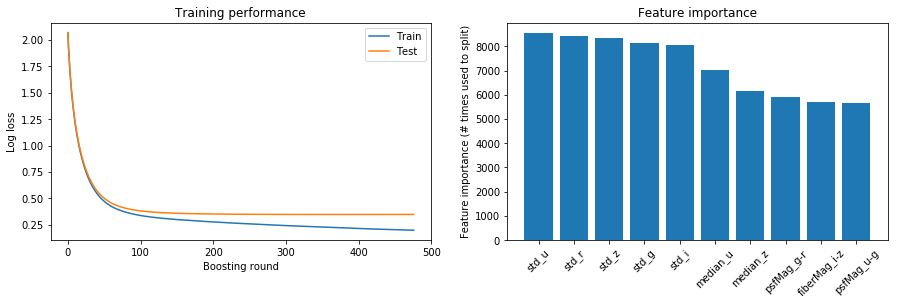

In [28]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [29]:
train_y_pred = lgmb_model.predict(X_test)
real_y_pred = lgmb_model.predict(test_X)

In [30]:
train_y_pred.shape

(59942, 19)

In [31]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.34746406023111365

In [32]:
lgmb_model.feature_importance()

array([3077, 3810, 5219, 4719, 4135, 3113, 3375, 3092, 3799, 3257, 3519,
       2653, 3370, 3446, 3465, 3189, 2769, 2855, 3044, 3900, 5645, 3022,
       2298, 2095, 5914, 2869, 2226, 5319, 3178, 5497, 5645, 2842, 2060,
       2369, 4790, 2688, 2276, 4928, 3776, 5695, 5344, 2974, 2432, 2509,
       3910, 2583, 2585, 5149, 2975, 5396, 5443, 2566, 2080, 2167, 4254,
       2552, 2095, 4570, 3603, 5640, 7026, 8547, 4950, 8148, 4873, 8438,
       4446, 8046, 6142, 8363])

### feature_importance

In [51]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df

,importance
std_u,8547
std_r,8438
std_z,8363
std_g,8148
std_i,8046
median_u,7026
median_z,6142
psfMag_g-r,5914
fiberMag_i-z,5695
psfMag_u-g,5645


### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0,2,7,11
망한예측 : 12,17

In [34]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [35]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,300,0,0,0,13,47,2,133,45,0,0,34,0,1,28,4,0,0,41
1,0,1881,0,0,0,1,1,4,11,0,1,4,0,0,0,0,1,0,47
2,0,0,75,64,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0
3,1,0,32,632,0,0,0,0,1,0,102,0,0,0,0,0,0,0,0
4,1,0,0,0,4247,40,0,0,7,0,0,11,0,0,0,79,0,0,0
5,35,0,0,0,124,3698,0,61,46,0,0,2,0,0,0,72,0,0,10
6,0,35,0,0,8,4,10890,3,63,3,1,60,0,85,16,14,0,0,2
7,152,0,0,0,0,198,0,725,20,0,0,2,0,0,0,1,0,0,298
8,21,11,2,1,28,207,86,30,13347,1,13,167,0,71,62,15,12,0,819
9,0,0,0,0,0,0,0,0,3,35,0,0,0,0,0,0,0,0,0


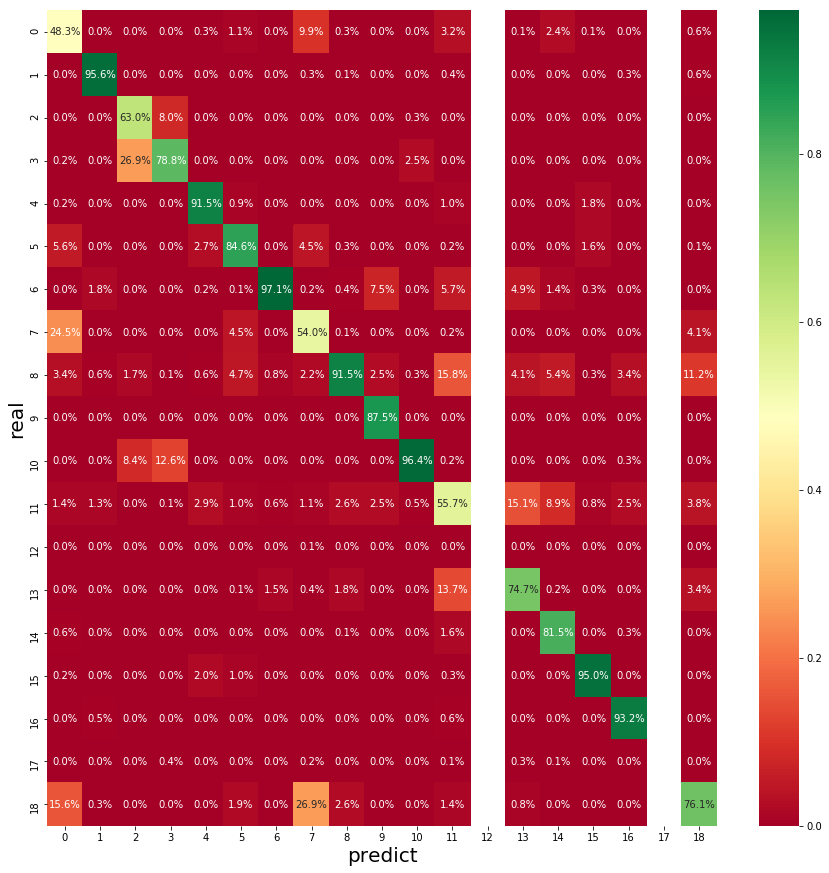

In [36]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

## Modeling_classification
* cv_number1
param = {'num_leaves': 255,
 'min_child_samples': 40,
 'max_depth': 8,
 'learning_rate': 0.05,
 'lambda_l2': 3,
 'lambda_l1': 9
}   
-> 결과 : 0.349561 
* cv_number2
param = {'num_leaves': 127, 'min_child_samples': 50, 'max_depth': 8, 'learning_rate': 0.01, 'lambda_l2': 7, 'lambda_l1': 9}  
  -> 결과 : 0.3612851294	

In [37]:
param = {'num_leaves': 255,
 'min_child_samples': 40,
 'max_depth': 8,
 'learning_rate': 0.05,
 'lambda_l2': 3,
 'lambda_l1': 9
}


In [38]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 127, min_child_samples = 50,
                            max_depth = 8, learning_rate = 0.01,
                            lambda_l2 = 7, lambda_l1 = 9,
                            n_estimators=2000, random_state = 42)

In [39]:
lgbm_c.fit(X_train, y_train, eval_set = [(X_train,y_train),(X_test, y_test)],eval_names= ['train','valid'], 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.908659	valid's multi_logloss: 0.924561
[200]	train's multi_logloss: 0.568311	valid's multi_logloss: 0.591111
[300]	train's multi_logloss: 0.436327	valid's multi_logloss: 0.46471
[400]	train's multi_logloss: 0.377413	valid's multi_logloss: 0.411104
[500]	train's multi_logloss: 0.344893	valid's multi_logloss: 0.38478
[600]	train's multi_logloss: 0.324985	valid's multi_logloss: 0.371194
[700]	train's multi_logloss: 0.311433	valid's multi_logloss: 0.363581
[800]	train's multi_logloss: 0.30076	valid's multi_logloss: 0.358827
[900]	train's multi_logloss: 0.29162	valid's multi_logloss: 0.355474
[1000]	train's multi_logloss: 0.283303	valid's multi_logloss: 0.353137
[1100]	train's multi_logloss: 0.275561	valid's multi_logloss: 0.351567
[1200]	train's multi_logloss: 0.268541	valid's multi_logloss: 0.35042
[1300]	train's multi_logloss: 0.261864	valid's multi_logloss: 0.349636
[1400]	train's multi_logloss:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=9, lambda_l2=7,
               learning_rate=0.01, max_depth=8, min_child_samples=50,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
               n_jobs=-1, num_leaves=127, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [40]:
train_y_pred = lgbm_c.predict_proba(X_test)

from sklearn.metrics import log_loss
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.3471234196482347

In [41]:
train_y_pred

array([[1.31563611e-03, 5.33445316e-05, 2.58854694e-05, ...,
        3.82898128e-05, 6.75176534e-05, 1.36672005e-04],
       [1.34961142e-03, 5.00179786e-04, 4.84167738e-05, ...,
        9.58912188e-05, 1.14034306e-04, 2.01920681e-01],
       [2.24540394e-05, 1.45998675e-05, 5.21171815e-06, ...,
        9.48418730e-06, 1.10913513e-05, 2.36966584e-05],
       ...,
       [9.39117621e-05, 8.81802864e-05, 3.29389372e-04, ...,
        2.74520886e-04, 3.82960961e-05, 6.77078462e-05],
       [1.20070431e-05, 7.21139844e-06, 2.20521787e-06, ...,
        2.83316870e-06, 3.48955775e-06, 8.44899671e-05],
       [5.31177770e-04, 6.27349271e-05, 1.95376160e-05, ...,
        3.24789337e-05, 5.25590239e-05, 1.05534776e-02]])

In [42]:
test_y_pred = lgbm_c.predict_proba(test_X)

In [43]:
test_y_pred

array([[1.49428999e-04, 1.49128902e-04, 8.06266891e-04, ...,
        4.26356702e-04, 2.53977465e-03, 3.08218556e-04],
       [4.74922508e-04, 3.63820296e-04, 8.61993701e-05, ...,
        1.47194649e-04, 3.23931311e-04, 6.91718428e-04],
       [7.76745466e-05, 3.00136662e-05, 7.84838319e-06, ...,
        1.51160624e-05, 3.12536420e-05, 1.05120902e-04],
       ...,
       [1.38910071e-04, 1.00300867e-04, 1.60297001e-05, ...,
        2.63165678e-05, 3.81973904e-05, 7.80437716e-03],
       [1.59439585e-05, 2.76872012e-05, 2.26168597e-06, ...,
        4.06594158e-06, 3.58307084e-06, 2.53038799e-04],
       [8.02599326e-04, 3.37260325e-05, 1.02942262e-05, ...,
        1.95515096e-05, 1.56343696e-05, 1.50952977e-04]])

### feature_importance

In [44]:
pi_df = pd.DataFrame(lgbm_c.feature_importances_, index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df

,importance
std_u,41646
std_g,41082
std_r,40443
std_z,39730
std_i,38542
median_u,34179
median_z,30401
psfMag_g-r,29503
psfMag_u-g,28287
modelMag_i-z,27838


### 예측결과에 대해
잘된예측 : 1,3,4,5,6,8,9,10,14,15,16,18  
중간예측 : 0,2,7,13  
망한예측 : 11,12,17

In [45]:
train_y_pred = lgbm_c.predict(X_test)

In [46]:
train_y_pred.shape

(59942,)

In [47]:
cm_result = pd.DataFrame(confusion_matrix(y_test,train_y_pred))

In [48]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,306,0,0,0,13,44,2,139,43,0,0,31,0,1,28,5,0,0,36
1,0,1883,0,0,0,1,0,4,10,0,1,3,0,0,0,0,1,0,48
2,0,0,79,62,0,0,0,0,0,1,8,0,0,0,0,0,0,0,0
3,1,0,32,633,0,0,0,0,1,0,101,0,0,0,0,0,0,0,0
4,2,0,0,0,4248,40,0,0,6,0,0,10,0,0,0,79,0,0,0
5,28,0,0,0,125,3700,0,66,44,0,0,4,0,0,0,73,0,0,8
6,1,35,0,0,9,3,10892,4,63,2,1,59,0,86,15,13,0,0,1
7,154,0,0,0,0,202,0,728,18,0,0,2,0,0,0,1,0,0,291
8,21,10,2,1,26,208,83,30,13341,1,13,171,0,70,64,16,14,0,822
9,0,0,0,0,0,0,0,0,2,36,0,0,0,0,0,0,0,0,0


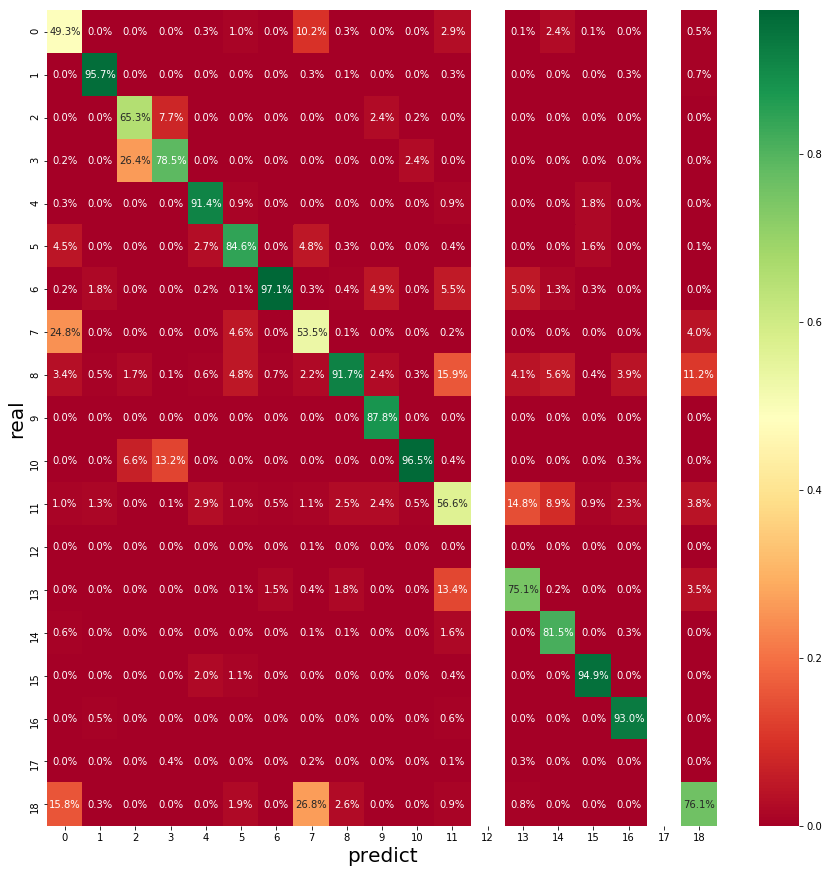

In [49]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [ ]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 255, min_child_samples = 40,
                            max_depth = 8, learning_rate = 0.1,
                            lambda_l2 = 3, lambda_l1 = 9,
                            n_estimators=2000, random_state = 42)

In [ ]:
lgbm_c.fit(train_X, train_y, eval_set = [(train_X, train_y)],eval_names= 'valid', 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

In [ ]:
f_train_y_pred = lgbm_c.predict_proba(train_X)

In [ ]:
y_pred = lgbm_c.predict_proba(test_X)

In [ ]:
y_pred

In [ ]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)